In [1]:
import pandas as pd
import matplotlib.pyplot as plt
file_path_1 = 'C:/Users/лепеха/OneDrive/Рабочий стол/Учеба/ETHUSD.csv'
file_path_2 = 'C:/Users/лепеха/OneDrive/Рабочий стол/Учеба/IceaCreamFrozenDessert.csv'
ETH_df = pd.read_csv(file_path_1)
IceCream_df = pd.read_csv(file_path_2)
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.losses import MeanSquaredError, MeanAbsolutePercentageError

In [2]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.losses import MeanSquaredError, MeanAbsolutePercentageError
from sklearn.metrics import mean_squared_error
from keras.layers import Dense, Dropout
from keras.losses import MeanSquaredError, MeanAbsoluteError, Huber, LogCosh
from keras.optimizers import Adam, SGD, RMSprop, Adagrad

In [3]:
ETH_df = ETH_df.dropna()

In [4]:
import torch
import torch.nn as nn
import numpy as np
import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# Подготовка данных
scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()

data1 = IceCream_df['value'].values.reshape(-1, 1)
data2 = ETH_df['Open'].values.reshape(-1, 1)

data1_scaled = scaler1.fit_transform(data1).T[0]
data2_scaled = scaler2.fit_transform(data2).T[0]

# Функция для создания оконных данных
def window_split(time_series, k):
    x = []
    y = []
    
    for i in range(len(time_series) - k + 1):
        x.append([time_series[i+j] for j in range(k)])
        
    for i in range(len(time_series) - k):
        y.append(time_series[i+k])
        
    return x[:-1], y

# Создание оконных данных для обучения
x_data1, y_data1 = window_split(data1_scaled, 10)
x_data2, y_data2 = window_split(data2_scaled, 4)

X1 = torch.FloatTensor(np.array(x_data1).reshape(len(x_data1), 10, 1))
X2 = torch.FloatTensor(np.array(x_data2).reshape(len(x_data2), 4, 1))

Y1 = torch.FloatTensor(y_data1)
Y2 = torch.FloatTensor(y_data2)

X_train1, X_test1 = X1[:-20], X1[-20:]
Y_train1, Y_test1 = Y1[:-20], Y1[-20:]

X_train2, X_test2 = X2[:-20], X2[-20:]
Y_train2, Y_test2 = Y2[:-20], Y2[-20:]

# Класс LSTM модели
class LSTM(nn.Module):
    def __init__(self, hidden_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = 1
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=self.num_layers, batch_first=True)
        self.linear_layer = nn.Linear(in_features=hidden_size * self.num_layers, out_features=1)

    def forward(self, inputs):
        h_0 = torch.zeros(self.num_layers, inputs.size(0), self.hidden_size)
        c_0 = torch.zeros(self.num_layers, inputs.size(0), self.hidden_size)

        output_features, (h_out, _) = self.lstm(inputs, (h_0, c_0))
        h_out = h_out.view(inputs.size(0), self.num_layers * self.hidden_size)
        out = self.linear_layer(h_out)
        
        return out

# Функция потерь MAE
class MAE(nn.Module):
    def __init__(self):
        super(MAE, self).__init__()

    def forward(self, x, y):
        return torch.mean(torch.abs(x - y))

# Класс модели для обучения
class Model:
    def __init__(self, optim_type, loss_type):
        self.optim_type = optim_type
        self.loss_type = loss_type
        self.LSTM = LSTM(2**7)
        
    def fit(self, X_train, Y_train, epochs=200, lr=0.01):
        epochs = tqdm.tqdm(range(epochs))
        
        if self.optim_type == 'Adam':
            optimizer = torch.optim.Adam(self.LSTM.parameters(), lr=lr)
        elif self.optim_type == 'Adagrad':
            optimizer = torch.optim.Adagrad(self.LSTM.parameters(), lr=lr)
        elif self.optim_type == 'RMSprop':
            optimizer = torch.optim.RMSprop(self.LSTM.parameters(), lr=lr)
        elif self.optim_type == 'SGD':
            optimizer = torch.optim.SGD(self.LSTM.parameters(), lr=lr)
        else:
            print('Choose optimizer type')
        
        if self.loss_type == 'MSE':
            criterion = nn.MSELoss()
        elif self.loss_type == 'MAE':
            criterion = MAE()
        
        losses = []
        for _ in epochs:
            pred = self.LSTM(X_train)
            loss = criterion(pred, Y_train.unsqueeze(1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epochs.set_description(f'Loss: {loss.item()}')
            losses.append(loss.item())
            
        return losses

# Обучение модели для различных функций потерь и оптимизаторов
pred_array1 = []
pred_array2 = []
losses_total1 = []
losses_total2 = []
loss_names = ['MSE', 'MAE']
optimizers = ['Adam', 'Adagrad', 'RMSprop', 'SGD']

for loss in loss_names:
    losses_array1 = []
    losses_array2 = []
    for opt in optimizers:
        model1 = Model(opt, loss)
        model2 = Model(opt, loss)
        
        losses1 = model1.fit(X_train1, Y_train1, epochs=2000, lr=0.001)
        losses2 = model2.fit(X_train2, Y_train2, epochs=2000, lr=0.001)
        
        prediction1 = model1.LSTM(X_test1).data.numpy()
        prediction2 = model2.LSTM(X_test2).data.numpy()
        
        prediction1 = scaler1.inverse_transform(prediction1)
        prediction2 = scaler2.inverse_transform(prediction2)
        
        pred_array1.append(prediction1)
        pred_array2.append(prediction2)
        
        losses_array1.append(losses1)
        losses_array2.append(losses2)
        
    losses_total1.append(losses_array1)
    losses_total2.append(losses_array2)

Loss: 0.0946967676281929: 100%|████████████████████████████████████████████████████| 2000/2000 [02:17<00:00, 14.50it/s]


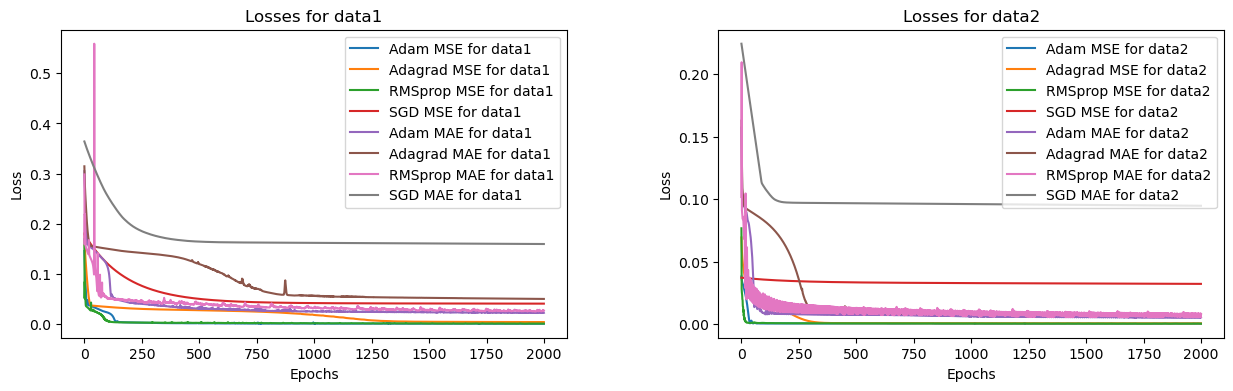

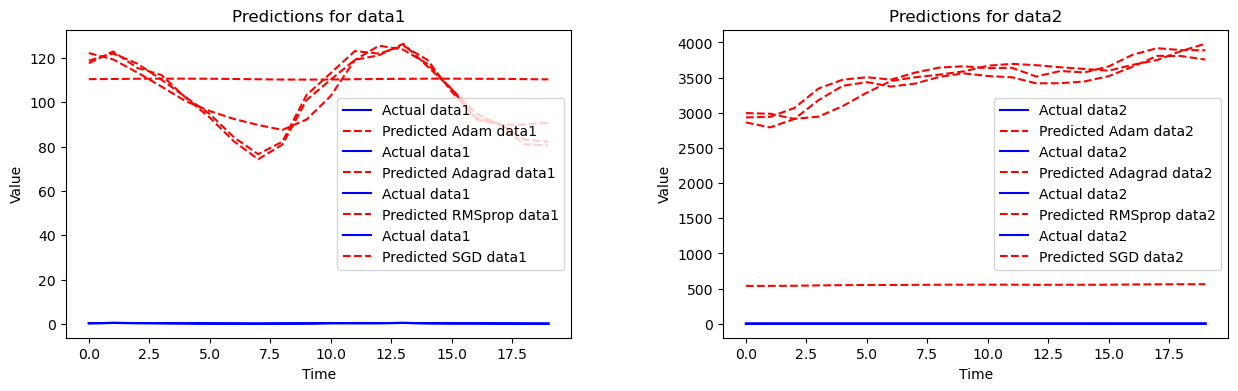

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4), dpi=100)

# Визуализация ошибок (лоссов)
for j in range(len(loss_names)):
    for i in range(len(optimizers)):
        axs[0].plot(losses_total1[j][i], label=optimizers[i] + ' ' + loss_names[j] + ' for data1')
        axs[1].plot(losses_total2[j][i], label=optimizers[i] + ' ' + loss_names[j] + ' for data2')
        
axs[0].legend()
axs[0].set_title('Losses for data1')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')

axs[1].legend()
axs[1].set_title('Losses for data2')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')

plt.subplots_adjust(wspace=0.3)    
plt.show()

# Визуализация прогнозов
fig, axs = plt.subplots(1, 2, figsize=(15, 4), dpi=100)

for i in range(len(optimizers)):
    axs[0].plot(Y_test1.numpy(), label='Actual data1', color='blue')
    axs[0].plot(pred_array1[i], label=f'Predicted {optimizers[i]} data1', linestyle='--', color='red')
    
    axs[1].plot(Y_test2.numpy(), label='Actual data2', color='blue')
    axs[1].plot(pred_array2[i], label=f'Predicted {optimizers[i]} data2', linestyle='--', color='red')

axs[0].legend()
axs[0].set_title('Predictions for data1')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Value')

axs[1].legend()
axs[1].set_title('Predictions for data2')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Value')

plt.subplots_adjust(wspace=0.3)    
plt.show()